In [48]:
import cupy as cp
import numpy as np
import cupyx.scipy.sparse as cusparse
import pyvista as pv
import vtk
import os

from gamma.simulator.gamma import domain_mgr, heat_solve_mgr
from gamma.simulator.func import transformation

# ✅ GPU 번호 설정
cp.cuda.Device(3).use()

# ✅ 도메인 및 열해석 초기화 (box.k & toolpath)
domain = domain_mgr(
    filename="box.k",
    toolpathdir="box_toolpath.crs"  # 필요 시 경로 수정
)
heat_solver = heat_solve_mgr(domain)

# ✅ 물성 데이터 로딩
poisson = 0.3
a1 = 10000
young1 = cp.array(np.loadtxt("/home/ftk3187/github/GAMMA/DED_GAMMA_solver/examples/0_properties/TI64_Young_Debroy.txt")[:,1]/1e6)
temp_young1 = cp.array(np.loadtxt("/home/ftk3187/github/GAMMA/DED_GAMMA_solver/examples/0_properties/TI64_Young_Debroy.txt")[:,0])
Y1 = cp.array(np.loadtxt("/home/ftk3187/github/GAMMA/DED_GAMMA_solver/examples/0_properties/TI64_Yield_Debroy.txt")[:,1]/1e6*np.sqrt(2/3))
temp_Y1 = cp.array(np.loadtxt("/home/ftk3187/github/GAMMA/DED_GAMMA_solver/examples/0_properties/TI64_Yield_Debroy.txt")[:,0])
scl1 = cp.array(np.loadtxt("/home/ftk3187/github/GAMMA/DED_GAMMA_solver/examples/0_properties/TI64_Alpha_Debroy.txt")[:,1])
temp_scl1 = cp.array(np.loadtxt("/home/ftk3187/github/GAMMA/DED_GAMMA_solver/examples/0_properties/TI64_Alpha_Debroy.txt")[:,0])
T_Ref = domain.ambient

# ✅ 시뮬레이션 상태 초기화
n_n = len(domain.nodes)
n_e = len(domain.elements)
n_q = 8
S = cp.zeros((n_e, n_q, 6))  # 응력 텐서만 초기화

nodes_pos = domain.nodes[domain.elements]
Jac = cp.matmul(domain.Bip_ele, nodes_pos[:, cp.newaxis, :, :].repeat(8, axis=1))
ele_detJac = cp.linalg.det(Jac)

# ✅ 저장 폴더 준비
os.makedirs("results_box", exist_ok=True)

# ✅ 결과 저장 함수 (온도 + von Mises 응력)
def save_vtk(filename):
    n_e_save = cp.sum(domain.active_elements)
    n_n_save = cp.sum(domain.active_nodes)
    active_elements = domain.elements[domain.active_elements].tolist()
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = domain.nodes[0:n_n_save].get()

    Sv = transformation(cp.sqrt(1/2 * ((S[0:n_e_save,:,0]-S[0:n_e_save,:,1])**2 +
                                       (S[0:n_e_save,:,1]-S[0:n_e_save,:,2])**2 +
                                       (S[0:n_e_save,:,2]-S[0:n_e_save,:,0])**2 +
                                       6*(S[0:n_e_save,:,3]**2 + S[0:n_e_save,:,4]**2 + S[0:n_e_save,:,5]**2))),
                        domain.elements[0:n_e_save], ele_detJac[0:n_e_save], n_n_save)

    grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    grid.point_data["temp"] = heat_solver.temperature[0:n_n_save].get()
    grid.point_data["S_von"] = Sv.get()
    grid.save(filename)

# ✅ 메인 시뮬레이션 루프 (열전달만 수행)
for step in range(50000):
    heat_solver.time_integration()
    
    if step % 200 == 0:
        print(f"Step: {step}, Time: {domain.current_sim_time:.4f}")
        save_vtk(f"results_box/box_{step:04d}.vtk")


Time of reading input files: 0.5047905445098877
Time of calculating critical timestep: 0.03243589401245117
Time of reading and interpolating toolpath: 0.023702383041381836
Number of nodes: 44636
Number of elements: 40187
Number of time-steps: 100000
Time of generating surface: 0.19829273223876953
Step: 0, Time: 0.0010
Step: 200, Time: 0.2010
Step: 400, Time: 0.4010
Step: 600, Time: 0.6010
Step: 800, Time: 0.8010
Step: 1000, Time: 1.0010
Step: 1200, Time: 1.2010
Step: 1400, Time: 1.4010
Step: 1600, Time: 1.6010
Step: 1800, Time: 1.8010
Step: 2000, Time: 2.0010
Step: 2200, Time: 2.2010
Step: 2400, Time: 2.4010
Step: 2600, Time: 2.6010
Step: 2800, Time: 2.8010
Step: 3000, Time: 3.0010
Step: 3200, Time: 3.2010
Step: 3400, Time: 3.4010
Step: 3600, Time: 3.6010
Step: 3800, Time: 3.8010
Step: 4000, Time: 4.0010
Step: 4200, Time: 4.2010
Step: 4400, Time: 4.4010
Step: 4600, Time: 4.6010
Step: 4800, Time: 4.8010
Step: 5000, Time: 5.0010
Step: 5200, Time: 5.2010
Step: 5400, Time: 5.4010
Step: 560

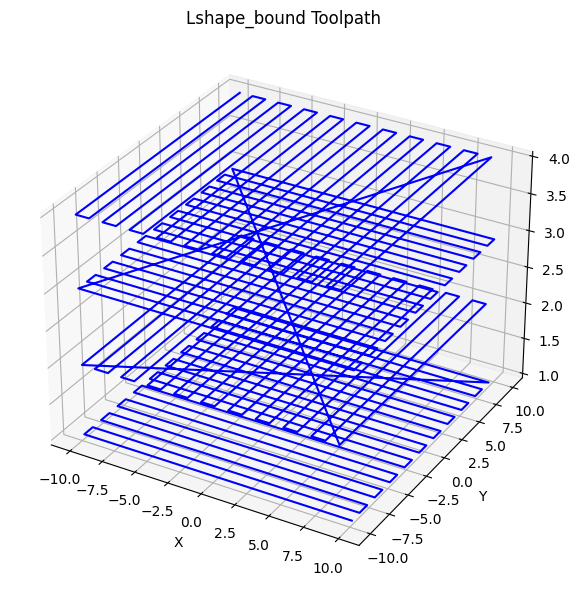

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Not strictly necessary unless using interactive backends

# 파일 경로
bound_path = "/home/ftk3187/github/GAMMA/DED_GAMMA_solver/00_toolpathgeneration/box_toolpath.crs"

# 데이터 불러오기
bound_data = np.loadtxt(bound_path)

# x, y, z 추출
bound_xyz = bound_data[:, 1:4]

# 플롯 생성 (1행 2열 구성, 현재는 1개만 사용)
fig = plt.figure(figsize=(14, 6))

# Bound toolpath plot (왼쪽)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(bound_xyz[:, 0], bound_xyz[:, 1], bound_xyz[:, 2], color='blue')
ax1.set_title("Lshape_bound Toolpath")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import os
os.chdir("/home/ftk3187/github/GAMMA/DED_GAMMA_solver/00_toolpathgeneration/")

%run /home/ftk3187/github/GAMMA/DED_GAMMA_solver/00_toolpathgeneration/main_box.py


Time of reading input files: 0.15802431106567383
Time of calculating critical timestep: 0.009808778762817383
Time of reading and interpolating toolpath: 0.0074274539947509766
Number of nodes: 12756
Number of elements: 10877
Number of time-steps: 19426
Time of generating surface: 0.053633928298950195
  stopping criterion = 1.00e+00
  Newton it=0, beta=1.00, criterion=1.00e+00
  stopping criterion = 2.29e-06
  Newton it=1, beta=1.00, criterion=2.29e-06
  stopping criterion = 8.14e-13
F = 0.005035643379921839
  stopping criterion = nan
  Newton it=0, beta=1.00, criterion=nan
  stopping criterion = nan
  Newton it=1, beta=1.00, criterion=nan
  stopping criterion = nan
  Newton it=2, beta=1.00, criterion=nan
  stopping criterion = nan
  Newton it=3, beta=1.00, criterion=nan
  stopping criterion = nan
  Newton it=4, beta=1.00, criterion=nan
  stopping criterion = nan
  Newton it=5, beta=1.00, criterion=nan
  stopping criterion = nan
  Newton it=6, beta=1.00, criterion=nan
  stopping criterio

Exception: Newton solver did not converge at timestep 20